- 用tensorboard/tensorboardX可视化pytorch结果

# TensorboardX 介绍

## 安装与启动

- 安装
> - pip install tensorboard
> - pip install tensorboardX

- 启动
> - tensorboard --logdir=tensorboard_log -host=127.0.0.1
> - http://127.0.0.1:6006

- -host=127.0.0.1是我自己添加的，不加的话也可以。但我自己电脑不加的话显示不出
- tensorboard要更新到最新版本，不然有些功能没有
- 数据量大的时候耐心等一等，可能要读取一会才出现

# TensorboardX 实例

## demo

In [1]:
import torch
import torchvision.utils as vutils
import numpy as np
import torchvision.models as models
from torchvision import datasets
from tensorboardX import SummaryWriter

resnet18 = models.resnet18(False)
writer = SummaryWriter(log_dir='tensorboard_log/demo', comment='demo')
sample_rate = 44100
freqs = [262, 294, 330, 349, 392, 440, 440, 440, 440, 440, 440]

for n_iter in range(100):

    dummy_s1 = torch.rand(1)
    dummy_s2 = torch.rand(1)
    # data grouping by `slash`
    writer.add_scalar('data/scalar1', dummy_s1[0], n_iter)
    writer.add_scalar('data/scalar2', dummy_s2[0], n_iter)

    writer.add_scalars('data/scalar_group', {'xsinx': n_iter * np.sin(n_iter),
                                             'xcosx': n_iter * np.cos(n_iter),
                                             'arctanx': np.arctan(n_iter)}, n_iter)

    dummy_img = torch.rand(32, 3, 64, 64)  # output from network
    if n_iter % 10 == 0:
        x = vutils.make_grid(dummy_img, normalize=True, scale_each=True)
        writer.add_image('Image', x, n_iter)

        dummy_audio = torch.zeros(sample_rate * 2)
        for i in range(x.size(0)):
            # amplitude of sound should in [-1, 1]
            dummy_audio[i] = np.cos(freqs[n_iter // 10] * np.pi * float(i) / float(sample_rate))
        writer.add_audio('myAudio', dummy_audio, n_iter, sample_rate=sample_rate)

        writer.add_text('Text', 'text logged at step:' + str(n_iter), n_iter)

        for name, param in resnet18.named_parameters():
            writer.add_histogram(name, param.clone().cpu().data.numpy(), n_iter)

        # needs tensorboard 0.4RC or later
        writer.add_pr_curve('xoxo', np.random.randint(2, size=100), np.random.rand(100), n_iter)

dataset = datasets.MNIST('mnist', train=False, download=True)
images = dataset.test_data[:100].float()
label = dataset.test_labels[:100]

features = images.view(100, 784)
writer.add_embedding(features, metadata=label, label_img=images.unsqueeze(1))

# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()

Processing...
Done!


## 线性拟合的训练过程中的loss可视化和模型的保存

Epoch 5/60,loss:0.1699
Epoch 10/60,loss:0.1699
Epoch 15/60,loss:0.1698
Epoch 20/60,loss:0.1698
Epoch 25/60,loss:0.1698
Epoch 30/60,loss:0.1698
Epoch 35/60,loss:0.1698
Epoch 40/60,loss:0.1697
Epoch 45/60,loss:0.1697
Epoch 50/60,loss:0.1697
Epoch 55/60,loss:0.1697
Epoch 60/60,loss:0.1697


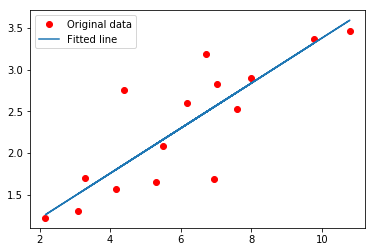

In [11]:
import torch
import torch.nn as nn
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

input_size = 1
output_size = 1
num_epoches = 60
learning_rate = 0.01
writer = SummaryWriter(log_dir='tensorboard_log/example', comment='Linear')
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168],
                    [9.779], [6.182], [7.59], [2.167], [7.042],
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)
y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573],
                    [3.366], [2.596], [2.53], [1.221], [2.827],
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

model = nn.Linear(input_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epoches):
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)

    output = model(inputs)
    loss = criterion(output, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 保存loss的数据与epoch数值
    writer.add_scalar('Train', loss, epoch)
    if (epoch + 1) % 5 == 0:
        print('Epoch {}/{},loss:{:.4f}'.format(epoch + 1, num_epoches, loss.item()))

# 将model保存为graph
writer.add_graph(model, (inputs,))

predicted = model(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()
writer.close()

# TensorboardX 可视化方式

## scalar 变量
- SummaryWriter: log_dir为生成的文件所放的目录，comment为文件名称
- writer.add_scalar('scalar/test', np.random.rand(), epoch)，这句代码的作用就是，将我们所需要的数据保存在文件里面供可视化使用。 
- 这里是Scalar类型，所以使用writer.add_scalar()，其他的队形使用对应的函数。
    - 第一个参数可以简单理解为保存图的名称，
    - 第二个参数是可以理解为Y轴数据，
    - 第三个参数可以理解为X轴数据。
    - 当Y轴数据不止一个时，可以使用writer.add_scalars().

In [10]:
import numpy as np
from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir='tensorboard_log/scalar')
for epoch in range(100):
    writer.add_scalar('test', np.random.rand(), epoch)
    writer.add_scalars('scalars_test', 
                       {'xsinx': epoch * np.sin(epoch), 
                        'xcosx': epoch * np.cos(epoch)}, epoch)

writer.close()

## Graph 神经网络架构
- 因为这是一个神经网络架构，所以使用 w.add_graph(model, (dummy_input,))
    - 第一个参数为需要保存的模型，
    - 第二个参数为输入值，元祖类型。

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter


class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn = nn.BatchNorm2d(20)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x) + F.relu(-x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


dummy_input = torch.rand(13, 1, 28, 28)

model = Net1()
# with 语句，可以避免因w.close未写造成的问题
with SummaryWriter(log_dir='tensorboard_log/graph', comment='Net1') as w:
    w.add_graph(model, (dummy_input,))

## embedding 降维

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.autograd.variable import Variable
from tensorboardX import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

# EMBEDDING VISUALIZATION FOR A TWO-CLASSES PROBLEM

# just a bunch of layers


class M(nn.Module):
    def __init__(self):
        super(M, self).__init__()
        self.cn1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        self.cn2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(in_features=128, out_features=2)

    def forward(self, i):
        i = self.cn1(i)
        i = F.relu(i)
        i = F.max_pool2d(i, 2)
        i = self.cn2(i)
        i = F.relu(i)
        i = F.max_pool2d(i, 2)
        i = i.view(len(i), -1)
        i = self.fc1(i)
        i = F.log_softmax(i, dim=1)
        return i

# get some random data around value


def get_data(value, shape):
    data = torch.ones(shape) * value
    # add some noise
    data += torch.randn(shape)**2
    return data


# dataset
# cat some data with different values
data = torch.cat(
    (get_data(
        0, (100, 1, 14, 14)), get_data(
            0.5, (100, 1, 14, 14))), 0)
# labels
labels = torch.cat((torch.zeros(100), torch.ones(100)), 0)
# generator
gen = DataLoader(TensorDataset(data, labels), batch_size=25, shuffle=True)
# network
m = M()
#loss and optim
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(params=m.parameters())
# settings for train and log
num_epochs = 20
embedding_log = 5
writer = SummaryWriter(log_dir='tensorboard_log/embedding', comment='mnist_embedding_training')

# TRAIN
for epoch in range(num_epochs):
    for j, sample in enumerate(gen):
        n_iter = (epoch * len(gen)) + j
        # reset grad
        m.zero_grad()
        optimizer.zero_grad()
        # get batch data
        data_batch = Variable(sample[0], requires_grad=True).float()
        label_batch = Variable(sample[1], requires_grad=False).long()
        # FORWARD
        out = m(data_batch)
        loss_value = loss(out, label_batch)
        # BACKWARD
        loss_value.backward()
        optimizer.step()
        # LOGGING
        writer.add_scalar('loss', loss_value.data.item(), n_iter)

        if j % embedding_log == 0:
            print("loss_value:{}".format(loss_value.data.item()))
            # we need 3 dimension for tensor to visualize it!
            out = torch.cat((out.data, torch.ones(len(out), 1)), 1)
            writer.add_embedding(
                out,
                metadata=label_batch.data,
                label_img=data_batch.data,
                global_step=n_iter)

writer.close()

# tensorboard --logdir runs
# you should now see a dropdown list with all the timestep,
# last timestep should have a visible separation between the two classes

loss_value:0.6920217871665955
loss_value:0.8206109404563904
loss_value:0.5653269290924072
loss_value:0.3914765417575836
loss_value:0.4490695893764496
loss_value:0.3116423487663269
loss_value:0.2449614703655243
loss_value:0.16987621784210205
loss_value:0.11793910712003708
loss_value:0.09033066779375076
loss_value:0.1099458634853363
loss_value:0.06549552828073502
loss_value:0.07312457263469696
loss_value:0.02840356156229973
loss_value:0.027275869622826576
loss_value:0.014830809086561203
loss_value:0.0212051123380661
loss_value:0.015640197321772575
loss_value:0.019302107393741608
loss_value:0.0127271618694067
loss_value:0.006987855304032564
loss_value:0.009496339596807957
loss_value:0.013434902764856815
loss_value:0.008479253388941288
loss_value:0.006454657297581434
loss_value:0.005604037083685398
loss_value:0.008889805525541306
loss_value:0.006641479674726725
loss_value:0.006279394030570984
loss_value:0.00678213220089674
loss_value:0.006556646898388863
loss_value:0.002577589126303792
los

### multiple_embedding

In [8]:
import math
import numpy as np
from tensorboardX import SummaryWriter


def main():
    degrees = np.linspace(0, 3600 * math.pi / 180.0, 3600)
    degrees = degrees.reshape(3600, 1)
    labels = ["%d" % (i) for i in range(0, 3600)]

    with SummaryWriter(log_dir='tensorboard_log/multiple_embedding', comment='multiple_embedding') as writer:
        # Maybe make a bunch of data that's always shifted in some
        # way, and that will be hard for PCA to turn into a sphere?

        for epoch in range(0, 16):
            shift = epoch * 2 * math.pi / 16.0
            mat = np.concatenate([
                np.sin(shift + degrees * 2 * math.pi / 180.0),
                np.sin(shift + degrees * 3 * math.pi / 180.0),
                np.sin(shift + degrees * 5 * math.pi / 180.0),
                np.sin(shift + degrees * 7 * math.pi / 180.0),
                np.sin(shift + degrees * 11 * math.pi / 180.0)
            ], axis=1)
            writer.add_embedding(
                mat=mat,
                metadata=labels,
                tag="sin",
                global_step=epoch)

            mat = np.concatenate([
                np.cos(shift + degrees * 2 * math.pi / 180.0),
                np.cos(shift + degrees * 3 * math.pi / 180.0),
                np.cos(shift + degrees * 5 * math.pi / 180.0),
                np.cos(shift + degrees * 7 * math.pi / 180.0),
                np.cos(shift + degrees * 11 * math.pi / 180.0)
            ], axis=1)
            writer.add_embedding(
                mat=mat,
                metadata=labels,
                tag="cos",
                global_step=epoch)

            mat = np.concatenate([
                np.tan(shift + degrees * 2 * math.pi / 180.0),
                np.tan(shift + degrees * 3 * math.pi / 180.0),
                np.tan(shift + degrees * 5 * math.pi / 180.0),
                np.tan(shift + degrees * 7 * math.pi / 180.0),
                np.tan(shift + degrees * 11 * math.pi / 180.0)
            ], axis=1)
            writer.add_embedding(
                mat=mat,
                metadata=labels,
                tag="tan",
                global_step=epoch)


# if __name__ == "__main__":
main()

# tensorboard --logdir runs
# Under "Projection, you should see
#  48 tensor found named
#     cos:cos-00000 to cos:cos-00016
#     sin:sin-00000 to sin:sin-00016
#     tan:tan-00000 to tan:tan-00016

## matplotlib

In [12]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')

fig = plt.figure()

c1 = plt.Circle((0.2, 0.5), 0.2, color='r')
c2 = plt.Circle((0.8, 0.5), 0.2, color='r')

ax = plt.gca()
ax.add_patch(c1)
ax.add_patch(c2)
plt.axis('scaled')


from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir='tensorboard_log/matplotlib', comment='matplotlib_plt')
writer.add_figure('matplotlib', fig)
writer.close()

## nvidia_smi GPU使用情况

In [1]:
from tensorboardX import SummaryWriter
import time
import torch

try:
    import nvidia_smi
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)  # gpu0
except ImportError:
    print('This demo needs nvidia-ml-py or nvidia-ml-py3')
    exit()

with SummaryWriter(log_dir='tensorboard_log/nvidia_smi', comment='nvidia_smi') as writer:
    x = []
    for n_iter in range(50):
        x.append(torch.Tensor(1000, 1000).cuda())
        res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
        writer.add_scalar('nv/gpu', res.gpu, n_iter)
        res = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        writer.add_scalar('nv/gpu_mem', res.used, n_iter)
        time.sleep(0.1)

This demo needs nvidia-ml-py or nvidia-ml-py3


## image 图片
- writer.add_image('Image', x, n_iter)

## audio
- writer.add_audio('myAudio', dummy_audio, n_iter, sample_rate=sample_rate)

## DISTRIBUTIONS和 HISTOGRAMS

In [ ]:
for name, param in resnet18.named_parameters():
    writer.add_histogram(name, param.clone().cpu().data.numpy(), n_iter)

## TEXT：
- writer.add_text('Text', 'text logged at step:' + str(n_iter), n_iter)

## PR CURVES:
- needs tensorboard 0.4RC or later
- writer.add_pr_curve('xoxo', np.random.randint(2, size=100), np.random.rand(100), n_iter)